In [ ]:
import os
import pandas as pd
import numpy as np
from numpy import expand_dims
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage.transform import resize
from IPython.display import SVG
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.utils import to_categorical, model_to_dot, plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger, ReduceLROnPlateau

In [ ]:
img_width, img_height = 80, 80 
channels = 3
batch_size = 64
num_images= 50
image_arr_size= img_width * img_height * channels

In [ ]:
import tensorflow as tf
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError: # If TPU not found
  tpu = None

# Select appropriate distribution strategy
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])  
else:
  tpu_strategy = tf.distribute.get_strategy() # Default strategy that works on CPU and single GPU
  print('Running on CPU instead')
print("Number of accelerators: ", tpu_strategy.num_replicas_in_sync)  

Running on CPU instead
Number of accelerators:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Load The Stanford Dogs Dataset**
The Stanford Dogs Dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.
Contents of the dataset:

Number of categories: 120
Number of images: 20,580
Annotations: Class labels, Bounding boxes

The dataset can be downloaded from http://vision.stanford.edu/aditya86/ImageNetDogs/.

In [ ]:
def get_images(image_dir):

    image_index = 0
    image_arr_size= img_width * img_height * channels
    images = np.ndarray(shape=(num_images, image_arr_size))
    labels = np.array([])                       

    for type in os.listdir(image_dir)[:50]:
        type_images = os.listdir(image_dir + type)
        labels= np.append(labels, type.split('-')[1])
        
        for image in type_images[:1]:
            image_file = os.path.join(image_dir, type + '/', image)
            image_data = mpimg.imread(image_file)
            image_resized = resize(image_data, (img_width, img_height), anti_aliasing=True)
            images[image_index, :] = image_resized.flatten()
            print (type, ':', image)
            image_index += 1

    return (images, labels)

def plot_images(instances, images_per_row=10, **options):
    size = img_width
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(img_width, img_height, channels) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((img_width, img_height * n_empty)))
    for row in range(n_rows):
        if (row == len(instances)/images_per_row):
            break
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.figure(figsize=(20,20))
    plt.imshow(image, **options)
    plt.axis("off")
    plt.savefig('dogs_images.png', transparent= True, bbox_inches= 'tight', dpi= 900)
    plt.show()

In [ ]:
%rm -d training_csv.log

rm: cannot remove 'training_csv.log': No such file or directory


In [ ]:
%cd /content/drive/MyDrive/Standford_Dogs_dataset/Images
%ls

In [ ]:
%cd /content/drive/MyDrive/Stanford_Dogs_dataset_10classes
%ls

/content/drive/MyDrive/Stanford_Dogs_dataset_10classes
n02085620-Chihuahua@         n02086910-papillon@
n02085782-Japanese_spaniel@  n02087046-toy_terrier@
n02085936-Maltese_dog@       n02087394-Rhodesian_ridgeback@
n02086079-Pekinese@          n02088094-Afghan_hound@
n02086240-Shih-Tzu@          n02088238-basset@
n02086646-Blenheim_spaniel@


In [ ]:
train_data_dir = '/content/drive/MyDrive/Stanford_Dogs_dataset/Images/'

In [ ]:
images, labels = get_images(train_data_dir)
plot_images(images)

n02088238-basset : n02088238_10095.jpg
n02085782-Japanese_spaniel : n02085782_1039.jpg
n02086910-papillon : n02086910_1199.jpg
n02085620-Chihuahua : n02085620_11238.jpg
n02088094-Afghan_hound : n02088094_10715.jpg
n02087046-toy_terrier : n02087046_1004.jpg
n02086240-Shih-Tzu : n02086240_1011.jpg
n02087394-Rhodesian_ridgeback : n02087394_10939.jpg
n02086646-Blenheim_spaniel : n02086646_1002.jpg
n02086079-Pekinese : n02086079_10603.jpg
n02085936-Maltese_dog : n02085936_10397.jpg
n02088364-beagle : n02088364_11136.jpg
n02088632-bluetick : n02088632_1077.jpg
n02089078-black-and-tan_coonhound : n02089078_1174.jpg
n02089867-Walker_hound : n02089867_1105.jpg
n02090379-redbone : n02090379_1345.jpg
n02090622-borzoi : n02090622_2055.jpg
n02091032-Italian_greyhound : n02091032_10300.jpg
n02091134-whippet : n02091134_10690.jpg
n02091467-Norwegian_elkhound : n02091467_1213.jpg
n02091831-Saluki : n02091831_1036.jpg
n02092339-Weimaraner : n02092339_1331.jpg
n02093256-Staffordshire_bullterrier : n0209

In [ ]:
print(images.shape, labels.shape)

(50, 16875) (50,)


# **Preprocessing**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,   
    validation_split=0.2,

)

valid_datagen = ImageDataGenerator(
    rescale= 1./255, 
    validation_split=0.2,
)

In [ ]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='training',
    shuffle= True, 
    seed= 1337
) 

valid_generator = valid_datagen.flow_from_directory(
    train_data_dir,
    target_size= (img_width, img_height),
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    subset='validation',
    shuffle= True, 
    seed= 1337
)

Found 1680 images belonging to 11 classes.
Found 414 images belonging to 11 classes.


In [ ]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)

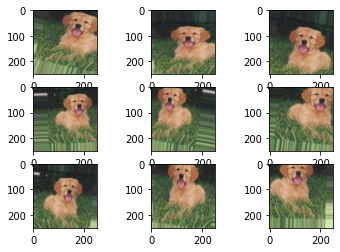

In [ ]:
img = load_img('/content/drive/MyDrive/Standford_Dogs_dataset/Images/n02099601-golden_retriever/n02099601_5.jpg')
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

# **InceptionV3 Model**

In [ ]:
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
# Rsnet50 = tf.keras.applications.ResNet50(weights='imagenet',
#                                                 include_top = False, 
#                                                 input_shape= (img_width, img_height, channels))
model = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False
#     print(layer,layer.trainable)
    
model.add(InceptionV3)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.2))
model.add(Dense(11,activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 11)                22539     
                                                                 
Total params: 21,825,323
Trainable params: 22,539
Non-trainable params: 21,802,784
_________________________________________________________________


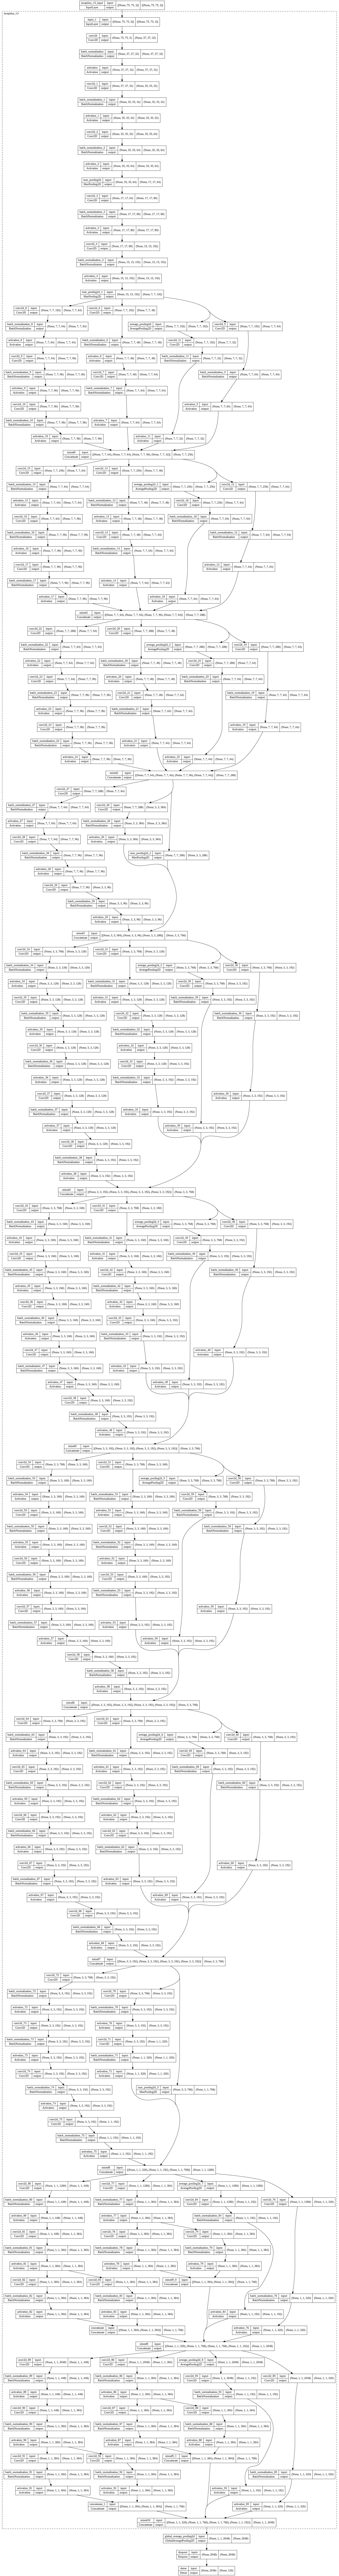

In [ ]:
SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

# **Baseline Model Training**

In [ ]:
model.compile(optimizer= keras.optimizers.Adam(learning_rate= 0.0001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [ ]:
SAVE_PERIOD = 10
STEPS_PER_EPOCH = train_labels.size / batch_size

checkpoint = ModelCheckpoint(
  'baseline_model.h5',
  monitor='val_loss',
  verbose=1,
  save_best_only=True,
  mode='auto',
  save_weights_only=False,
  save_freq= int(SAVE_PERIOD * STEPS_PER_EPOCH))

earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=3,
    verbose=1,
    mode='auto'
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduceLR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint, earlystop, csvlogger,reduceLR]

In [ ]:
history = model.fit(
  train_generator, 
  epochs = 100,
  steps_per_epoch = nb_train_samples//batch_size,
  validation_data = valid_generator, 
  validation_steps = nb_valid_samples//batch_size,
  verbose = 2, 
  # callbacks = callbacks,
  shuffle = True)

Epoch 1/100
26/26 - 426s - loss: 3.5461 - accuracy: 0.0922 - val_loss: 3.1893 - val_accuracy: 0.0833 - 426s/epoch - 16s/step
Epoch 2/100
26/26 - 15s - loss: 3.1899 - accuracy: 0.1071 - val_loss: 2.9604 - val_accuracy: 0.1250 - 15s/epoch - 558ms/step
Epoch 3/100
26/26 - 15s - loss: 3.1207 - accuracy: 0.1126 - val_loss: 2.8420 - val_accuracy: 0.1276 - 15s/epoch - 560ms/step
Epoch 4/100
26/26 - 15s - loss: 2.9594 - accuracy: 0.1466 - val_loss: 2.7563 - val_accuracy: 0.1380 - 15s/epoch - 585ms/step
Epoch 5/100
26/26 - 15s - loss: 2.8587 - accuracy: 0.1553 - val_loss: 2.6531 - val_accuracy: 0.1719 - 15s/epoch - 559ms/step
Epoch 6/100
26/26 - 14s - loss: 2.7942 - accuracy: 0.1615 - val_loss: 2.5564 - val_accuracy: 0.1927 - 14s/epoch - 553ms/step
Epoch 7/100
26/26 - 14s - loss: 2.6309 - accuracy: 0.2104 - val_loss: 2.5128 - val_accuracy: 0.1927 - 14s/epoch - 557ms/step
Epoch 8/100
26/26 - 14s - loss: 2.6214 - accuracy: 0.2024 - val_loss: 2.4588 - val_accuracy: 0.2135 - 14s/epoch - 553ms/step


In [ ]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)

7/7 [==============================] - 5s 819ms/step - loss: 1.7803 - accuracy: 0.4324
Validation Loss:  1.7803367376327515
Validation Accuracy:  0.43236714601516724


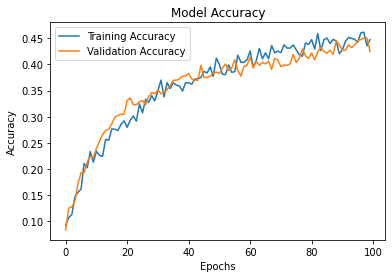

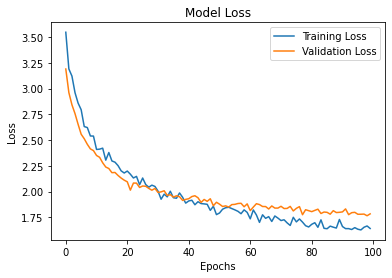

In [ ]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight', dpi= 900)
plt.show()

In [ ]:
model_path = "/content/drive/MyDrive/"
model.save(model_path+"InceptionV3_isolated_model_100epoch_stanford_dogs_11classes.h5")